In [ ]:
# Kolejnym etapem projektu jest próba poprawienia parametrów modelu wykorzystując automatyczną selekcję cech.
# W tym celu zbiór danych LDAP.csv, na którym pierwotnie były trenowane wszystkie modele zostanie poddany
# procesowi automaatycznego wybrania cech poprzez SelectKBest

In [1]:
# Wszystkie wymagane importy

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif


In [2]:
# Wczytanie danych
path = "data/LDAP.csv"
dataframe = pd.read_csv(path, low_memory=False)

In [3]:
# Ustawienie wyświetlania wszytskich kolumn i wierszy
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [4]:
# Wyświetlenie ilości w klasach
print (sorted(Counter(dataframe[" Label"]).items()))

[('BENIGN', 5124), ('LDAP', 1905191), ('NetBIOS', 202919)]


In [5]:
# Dzielenie dataframe na klasy

benign = dataframe[dataframe[' Label'] == 'BENIGN']
ldap = dataframe[dataframe[' Label'] == 'LDAP']
netbios = dataframe[dataframe[' Label'] == 'NetBIOS']

# Losowanie próbek z każdej klasy
benign_sampled = benign.sample(n=5000, random_state=42)
ldap_sampled = ldap.sample(n=2500, random_state=42)
netbios_sampled = netbios.sample(n=2500, random_state=42)

# Połączenie danych
df_balanced = pd.concat([benign_sampled, ldap_sampled, netbios_sampled])

# Stworzenie nowych X i Y
X = df_balanced.drop(columns=[' Label'])  # Zakładamy, że kolumna 'label' zawiera etykiety
Y = df_balanced[' Label']

# Sprawdzenie zbalansowania danych w X i Y
print(X.shape)
print(Y.shape)

(10000, 87)
(10000,)


In [6]:
# Ponowne wyświetlenie ilości w klasach
print (sorted(Counter(df_balanced[" Label"]).items()))

[('BENIGN', 5000), ('LDAP', 2500), ('NetBIOS', 2500)]


In [7]:
# Usunięcie pierwszej kolumny 'Unnamed'
dataframe = X.drop(dataframe.columns[0], axis=1)

dataframe_cleaned = X.drop(dataframe.columns[0], axis=1)

In [8]:
# # Usunięcie kolumn zawierających dane tekstowe
dataframe_cleaned = X.select_dtypes(exclude=['object', 'string'])
print(dataframe_cleaned.head())

        Unnamed: 0   Source Port   Destination Port   Protocol  \
203374      207362         55882                443          6   
204627       16634         60039                443          6   
203888      139390         62468                 53         17   
204033      156362         62981                 53         17   
204270       53526         58583                 53         17   

         Flow Duration   Total Fwd Packets   Total Backward Packets  \
203374           25654                   1                        2   
204627               3                   2                        0   
203888           45177                   2                        2   
204033           20945                   2                        2   
204270           20792                   2                        2   

        Total Length of Fwd Packets   Total Length of Bwd Packets  \
203374                          0.0                          12.0   
204627                         12.0   

In [9]:
# Usunięcie kolumn zawierających dane tekstowe
dataframe_cleaned = X.select_dtypes(exclude=['object', 'string'])

In [10]:
# Spradzenie, czy dane się zgadzają
print(dataframe_cleaned.head())

        Unnamed: 0   Source Port   Destination Port   Protocol  \
203374      207362         55882                443          6   
204627       16634         60039                443          6   
203888      139390         62468                 53         17   
204033      156362         62981                 53         17   
204270       53526         58583                 53         17   

         Flow Duration   Total Fwd Packets   Total Backward Packets  \
203374           25654                   1                        2   
204627               3                   2                        0   
203888           45177                   2                        2   
204033           20945                   2                        2   
204270           20792                   2                        2   

        Total Length of Fwd Packets   Total Length of Bwd Packets  \
203374                          0.0                          12.0   
204627                         12.0   

In [11]:
# Sprawdzenie obecności wartości inf i -inf w danych
print(np.isinf(dataframe_cleaned).sum())  # Liczba wartości inf w każdej kolumnie

Unnamed: 0                        0
 Source Port                      0
 Destination Port                 0
 Protocol                         0
 Flow Duration                    0
 Total Fwd Packets                0
 Total Backward Packets           0
Total Length of Fwd Packets       0
 Total Length of Bwd Packets      0
 Fwd Packet Length Max            0
 Fwd Packet Length Min            0
 Fwd Packet Length Mean           0
 Fwd Packet Length Std            0
Bwd Packet Length Max             0
 Bwd Packet Length Min            0
 Bwd Packet Length Mean           0
 Bwd Packet Length Std            0
Flow Bytes/s                    231
 Flow Packets/s                 243
 Flow IAT Mean                    0
 Flow IAT Std                     0
 Flow IAT Max                     0
 Flow IAT Min                     0
Fwd IAT Total                     0
 Fwd IAT Mean                     0
 Fwd IAT Std                      0
 Fwd IAT Max                      0
 Fwd IAT Min                

In [12]:
# Zastąpienie wartości inf lub -inf np. średnią danej kolumny
dataframe_cleaned = dataframe_cleaned.replace([np.inf, -np.inf], np.nan)  # Zamiana inf na NaN
dataframe_cleaned = dataframe_cleaned.fillna(dataframe_cleaned.mean())  # Wypełnianie NaN średnią

In [13]:
# Ponowne sprawdzenie obecności wartości inf i -inf w danych
print(np.isinf(dataframe_cleaned).sum())  # Liczba wartości inf w każdej kolumnie

Unnamed: 0                      0
 Source Port                    0
 Destination Port               0
 Protocol                       0
 Flow Duration                  0
 Total Fwd Packets              0
 Total Backward Packets         0
Total Length of Fwd Packets     0
 Total Length of Bwd Packets    0
 Fwd Packet Length Max          0
 Fwd Packet Length Min          0
 Fwd Packet Length Mean         0
 Fwd Packet Length Std          0
Bwd Packet Length Max           0
 Bwd Packet Length Min          0
 Bwd Packet Length Mean         0
 Bwd Packet Length Std          0
Flow Bytes/s                    0
 Flow Packets/s                 0
 Flow IAT Mean                  0
 Flow IAT Std                   0
 Flow IAT Max                   0
 Flow IAT Min                   0
Fwd IAT Total                   0
 Fwd IAT Mean                   0
 Fwd IAT Std                    0
 Fwd IAT Max                    0
 Fwd IAT Min                    0
Bwd IAT Total                   0
 Bwd IAT Mean 

In [14]:
# Sprawdzenie, czy są brakujące wartości
print(dataframe_cleaned.isna().sum())  # Liczba brakujących wartości w każdej kolumnie

Unnamed: 0                      0
 Source Port                    0
 Destination Port               0
 Protocol                       0
 Flow Duration                  0
 Total Fwd Packets              0
 Total Backward Packets         0
Total Length of Fwd Packets     0
 Total Length of Bwd Packets    0
 Fwd Packet Length Max          0
 Fwd Packet Length Min          0
 Fwd Packet Length Mean         0
 Fwd Packet Length Std          0
Bwd Packet Length Max           0
 Bwd Packet Length Min          0
 Bwd Packet Length Mean         0
 Bwd Packet Length Std          0
Flow Bytes/s                    0
 Flow Packets/s                 0
 Flow IAT Mean                  0
 Flow IAT Std                   0
 Flow IAT Max                   0
 Flow IAT Min                   0
Fwd IAT Total                   0
 Fwd IAT Mean                   0
 Fwd IAT Std                    0
 Fwd IAT Max                    0
 Fwd IAT Min                    0
Bwd IAT Total                   0
 Bwd IAT Mean 

In [15]:
# Standaryzacja cech
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataframe_cleaned)

In [16]:
# Usuwamy cechy, które mają stałą wartość w całym zbiorze, ponieważ inforamcje te w żaden sposób nie wpływają na wynik klasyfikatora
dataframe_cleaned = dataframe_cleaned.loc[:, dataframe_cleaned.nunique() > 1]

In [17]:
# Wybieramy 15 najlepszych cech
selector = SelectKBest(score_func=f_classif, k=15)
X_new = selector.fit_transform(dataframe_cleaned, Y)

In [18]:
# Wyświetlamy wybrane cechy
print("Wybrane cechy:", selector.get_support(indices=True))

Wybrane cechy: [ 1  3  9 10 11 17 18 36 38 39 40 46 49 50 69]


In [19]:
# Wyświetlenie nazw wybranych cech
selected_features = dataframe_cleaned.columns[selector.get_support(indices=True)]
print("Nazwy wybranych cech:", selected_features)

Nazwy wybranych cech: Index([' Source Port', ' Protocol', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean', 'Flow Bytes/s',
       ' Flow Packets/s', 'Fwd Packets/s', ' Min Packet Length',
       ' Max Packet Length', ' Packet Length Mean', ' URG Flag Count',
       ' Average Packet Size', ' Avg Fwd Segment Size', ' Inbound'],
      dtype='object')


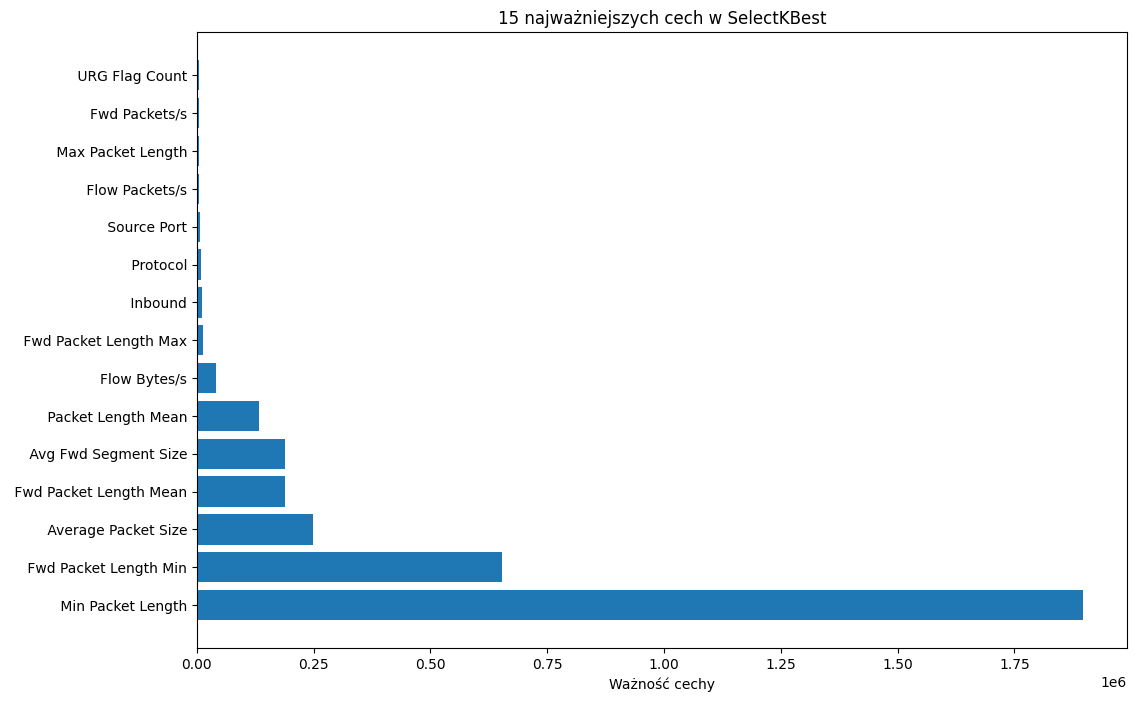

In [20]:
# Zastosowanie SelectKBest na wszystkich cechach
selector = SelectKBest(score_func=f_classif, k='all')  # 'all' oznacza wszystkie cechy
selector.fit(dataframe_cleaned, Y)

# Uzyskanie wyników (ważności) dla wszystkich cech
importance_scores = selector.scores_

# Tworzenie DataFrame z wynikami
importance_df = pd.DataFrame({'Feature': dataframe_cleaned.columns, 'Importance': importance_scores})

# Sortowanie po ważności (od najwyższej do najniższej)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Wybieramy top 15 cech
top_15_features = importance_df.head(15)

# Tworzenie wykresu słupkowego dla 15 najważniejszych cech
plt.figure(figsize=(12, 8))
plt.barh(top_15_features['Feature'], top_15_features['Importance'])
plt.xlabel('Ważność cechy')
plt.title('15 najważniejszych cech w SelectKBest')
plt.show()


In [ ]:
# Według algorytmu najważniejszymi cechami są Min Packet Length, Fwd Packet Length Min, Average Packet Size

In [21]:
# Utworzenie dataframe z cechami wybranymi przez algorytm
dataframe_cleaned = dataframe_cleaned[selected_features]

In [22]:
# Podział na dane treningowe i testowe
X_train, X_test, Y_train, Y_test = train_test_split(dataframe_cleaned, Y, test_size=0.2, random_state=42)

In [23]:
# Tworzenie modelu Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Trenowanie modelu na danych treningowych
model.fit(X_train, Y_train)

# Zapisanie modelu do pliku
joblib.dump(model, 'undersampling_model_auto_feature_selection.pkl')

# Predykcja na danych testowych
Y_pred = model.predict(X_test)

# Ocena dokładności modelu
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

# Wyświetlanie raportu klasyfikacji
print(classification_report(Y_test, Y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00      1012
        LDAP       1.00      1.00      1.00       492
     NetBIOS       1.00      1.00      1.00       496

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [ ]:
# Wstępna dokładność modelu jest idealna i wynosi 1.0

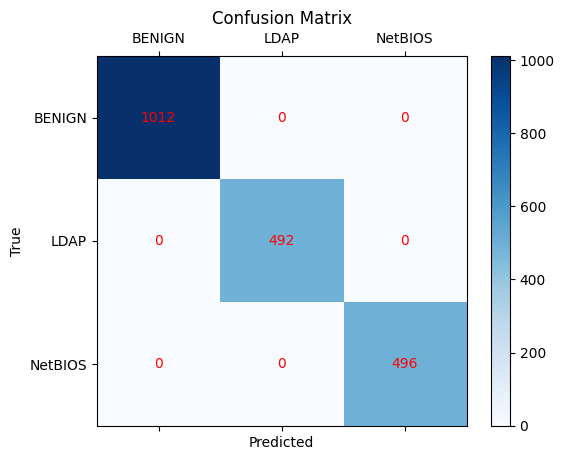

In [24]:
# Obliczenie macierzy pomyłek
cm = confusion_matrix(Y_test, Y_pred)

# Wykres macierzy pomyłek
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap='Blues')
fig.colorbar(cax)

# Etykiety osi
ax.set_xticks(np.arange(len(model.classes_)))
ax.set_yticks(np.arange(len(model.classes_)))

# Etykiety osi
ax.set_xticklabels(model.classes_)
ax.set_yticklabels(model.classes_)

# Etykiety osi
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Dodanie wartości liczbowych w komórkach
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, val, ha='center', va='center', color='red')

plt.show()

In [ ]:
# Według macierzy błędów algorytm przyporządkował właściwie każdą próbkę. Jednakże jak pokazały poprzednie modele
# wartości te nie oddają w pełni skuteczności modelu dla danych ogolnych. Z tego powodu przeprowadzono test modelu na nowych danych,
# jest to proces analogiczny do poprzednich.

In [25]:
# Wszystkie wymagane importy

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

In [26]:
# Wczytanie danych testowych
path = "data/NetBIOS.csv"

dataframe_test = pd.read_csv(path, low_memory=False)

In [27]:
# wykorzystanie tylko wcześniej wybranych cech
X_2 = dataframe_test[selected_features]
Y_2 = dataframe_test[' Label']

In [28]:
# Sprawdzenie, czy są brakujące wartości
# Liczba brakujących wartości w każdej kolumnie
print(X_2.isna().sum())

# Wypełnianie brakujących wartości średnią
X_2 = X_2.fillna(X_2.mean())

# Sprawdzenie, czy są brakujące wartości
# Liczba brakujących wartości w każdej kolumnie
print(X_2.isna().sum())  

# Sprawdzenie obecności wartości inf i -inf w danych
# Liczba wartości inf w każdej kolumnie
print(np.isinf(X_2).sum())  

# Zastąpienie wartości inf lub -inf np. średnią danej kolumny
# Zamiana inf na NaN
X_2 = X_2.replace([np.inf, -np.inf], np.nan)

# Wypełnianie NaN średnią
X_2 = X_2.fillna(X_2.mean())

# Sprawdzenie obecności wartości inf i -inf w danych
# Liczba wartości inf w każdej kolumnie
print(np.isinf(X_2).sum()) 

# Standaryzacja cech
scaler = StandardScaler()
X_2_scaled = scaler.fit_transform(X_2)

# Normalizacja cech do zakresu [0, 1]
scaler = MinMaxScaler()
X_2_normalized = scaler.fit_transform(X_2)

 Source Port               0
 Protocol                  0
 Fwd Packet Length Max     0
 Fwd Packet Length Min     0
 Fwd Packet Length Mean    0
Flow Bytes/s               6
 Flow Packets/s            0
Fwd Packets/s              0
 Min Packet Length         0
 Max Packet Length         0
 Packet Length Mean        0
 URG Flag Count            0
 Average Packet Size       0
 Avg Fwd Segment Size      0
 Inbound                   0
dtype: int64
 Source Port               0
 Protocol                  0
 Fwd Packet Length Max     0
 Fwd Packet Length Min     0
 Fwd Packet Length Mean    0
Flow Bytes/s               0
 Flow Packets/s            0
Fwd Packets/s              0
 Min Packet Length         0
 Max Packet Length         0
 Packet Length Mean        0
 URG Flag Count            0
 Average Packet Size       0
 Avg Fwd Segment Size      0
 Inbound                   0
dtype: int64
 Source Port                    0
 Protocol                       0
 Fwd Packet Length Max          0
 F

In [29]:
# Zastąpienie wartości inf lub -inf np. średnią danej kolumny
X_2 = X_2.replace([np.inf, -np.inf], np.nan)  # Zamiana inf na NaN
X_2 = X_2.fillna(X_2.mean())  # Wypełnianie NaN średnią

In [30]:
# Ponowne sprawdzenie obecności wartości inf i -inf w danych
print(np.isinf(dataframe_cleaned).sum())  # Liczba wartości inf w każdej kolumnie

 Source Port               0
 Protocol                  0
 Fwd Packet Length Max     0
 Fwd Packet Length Min     0
 Fwd Packet Length Mean    0
Flow Bytes/s               0
 Flow Packets/s            0
Fwd Packets/s              0
 Min Packet Length         0
 Max Packet Length         0
 Packet Length Mean        0
 URG Flag Count            0
 Average Packet Size       0
 Avg Fwd Segment Size      0
 Inbound                   0
dtype: int64


In [31]:
# Sprawdzenie, czy są brakujące wartości
print(dataframe_cleaned.isna().sum())  # Liczba brakujących wartości w każdej kolumnie

 Source Port               0
 Protocol                  0
 Fwd Packet Length Max     0
 Fwd Packet Length Min     0
 Fwd Packet Length Mean    0
Flow Bytes/s               0
 Flow Packets/s            0
Fwd Packets/s              0
 Min Packet Length         0
 Max Packet Length         0
 Packet Length Mean        0
 URG Flag Count            0
 Average Packet Size       0
 Avg Fwd Segment Size      0
 Inbound                   0
dtype: int64


In [32]:
# Predykcja na nowych danych testowych
Y_2_pred = model.predict(X_2)  # Jeśli używasz X_2_scaled

# Ocena dokładności modelu
accuracy = accuracy_score(Y_2, Y_2_pred)
print("Accuracy:", accuracy)

# Raport klasyfikacji
print("\nClassification Report:")
# print(classification_report(Y_2, Y_2_pred))

# Raport klasyfikacji z parametrem zero_division
print(classification_report(Y_2, Y_2_pred, zero_division=1))

Accuracy: 0.9996958823160051

Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.58      1.00      0.73      1321
        LDAP       0.00      1.00      0.00         0
     NetBIOS       1.00      1.00      1.00   3454578

    accuracy                           1.00   3455899
   macro avg       0.53      1.00      0.58   3455899
weighted avg       1.00      1.00      1.00   3455899



In [ ]:
# Skuteczność modelu, który został wytrenowany na podstawie automatycznie wybranych cech na nowym zbiorze danych testowych jest niemalże idealna.
# Model osiągnął skuteczność na poziomie 0.9996958823160051.

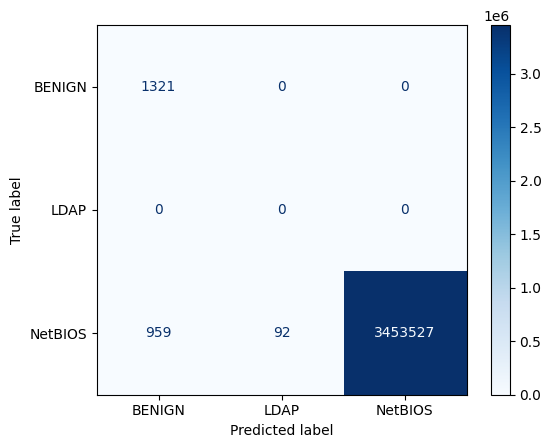

In [33]:
# Obliczenie macierzy pomyłek
cm = confusion_matrix(Y_2, Y_2_pred)

# Wizualizacja macierzy pomyłek
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# Formatowanie wartości w macierzy pomyłek jako liczby całkowite
disp.plot(cmap='Blues', values_format='d')

# Wyświetlenie wykresu
plt.show()


In [1]:
# Macierz błędów również potwierdza, że algorytm działa w sposób prawidłowy. Cały ruch łagodny został poprawnie sklasyfikowany.
# W przypadku ruchu NetBIOS (atakujący) zdxecydowana większość próbek została poprawnie sklasyfikowana. Tylko 959 próbek ruchu atakującego
# została sklasyfikowana jako ruch łagodny, a aż 34 53 527 próbek ruchu NetBIOS została poprawnie sklasyfikowana jako NetBios.

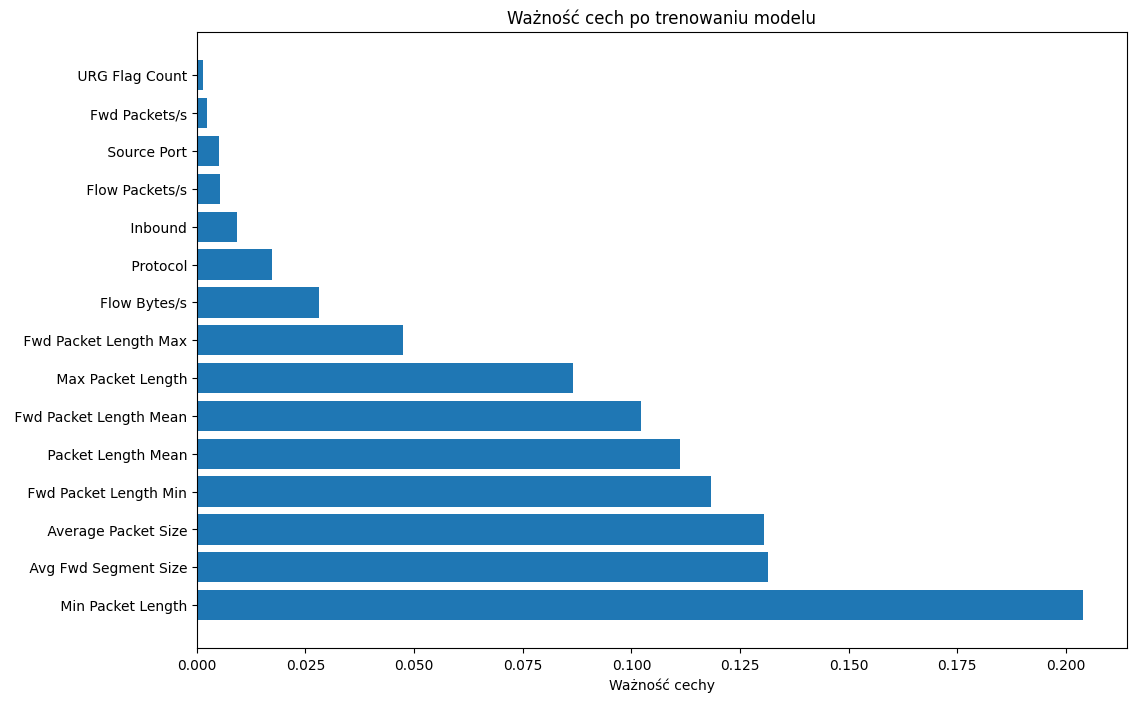

                    Feature  Importance
8         Min Packet Length    0.203812
13     Avg Fwd Segment Size    0.131528
12      Average Packet Size    0.130487
3     Fwd Packet Length Min    0.118375
10       Packet Length Mean    0.111065
4    Fwd Packet Length Mean    0.102168
9         Max Packet Length    0.086473
2     Fwd Packet Length Max    0.047441
5              Flow Bytes/s    0.028014
1                  Protocol    0.017393
14                  Inbound    0.009250
6            Flow Packets/s    0.005361
0               Source Port    0.005051
7             Fwd Packets/s    0.002224
11           URG Flag Count    0.001359


In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Załóżmy, że masz wytrenowany model 'model' i dane 'X'
importances = model.feature_importances_

# Tworzymy DataFrame z wynikami
importance_df = pd.DataFrame({'Feature': X_2.columns, 'Importance': importances})

# Sortujemy cechy według ważności
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Wyświetlamy wykres ważności cech
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Ważność cechy')
plt.title('Ważność cech po trenowaniu modelu')
plt.show()

# Wyświetlamy wyniki
print(importance_df)


In [ ]:
# Badanie ważności cech, na podstawie których model dokonał klasyfikacji wskazuje, że cechą wiodącą była Min Packet Length, jednakże
# cechy takie jak: Avg Fwd Segment Size, Average Packet Size, Fwd Packet Length Min, Packet Length Mean, Fwd Packet Length Max
# również miały istotny wpływ na decyzję modelu. 

# Taki wynik jest wynikiem satysfakcjonującym, ponieważ żadna z cech nie wybija się drastycznie na tle innych, a model
# podejmuje decyzję w oparciu o wiele cech. Dzięki takiemu rozłożeniu decyzje podejmowane przez model są niezwykle trafne.